# import

In [1]:
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotly.express as px

In [2]:
data = pd.read_csv("../data/data.csv", index_col=[0])

In [3]:
# Create dictionaries that store information about the indicator-columns
academic_indicator_dict = {
    'unilist' : [x for x in data.columns if 'prob_to_read_share' in x],
    'litges' : [x for x in data.columns if 'page_count_rel_litges' in x],
    'vv' : [x for x in data.columns if 'event_count_rel_vv' in x],
    'lexica' : ['killy_length'],
    'editions' : ['reclam_count'],
    'bibliographies' : ['BDSL_hits_2000_all']
}

other_indicator_dict = {
    'staatsexamen' : ['staatsexamen_count'],
    'schullist' : [x for x in data.columns if 'schullist_' in x and 'share' in x],
    'abi' : ['abi_mentions'],
    'kanonspiel' : ['kanonspiel_points'],
    'segebrecht' : ['segebrecht_count'],
    'vv_hein' : ['vv_hein_count'],
    'wiki' : ['wiki_length_in_words']
}

all_indicator_dict = {**academic_indicator_dict, **other_indicator_dict}

In [4]:
# Statistics about indictors
print("Number of primary indicators: ", len(all_indicator_dict.keys()))
print("Number of secondary indicators: ", len([element for innerList in list(all_indicator_dict.values()) for element in innerList]))   

print("Number of primary indicators for academic canonicity: ", len(academic_indicator_dict.keys()))
print("Number of secondary indicators for academic canonicity: ", \
      len([element for innerList in list(academic_indicator_dict.values()) for element in innerList]))      

Number of primary indicators:  13
Number of secondary indicators:  69
Number of primary indicators for academic canonicity:  6
Number of secondary indicators for academic canonicity:  50


# gnd filter

In [5]:
# Define relevant filters

relevant_occupations = [
    'Schriftsteller', 'Schriftstellerin', 'Dramatiker',
    'Lyriker', 'Drehbuchautor', 'Librettist',
    'Autor', 'Lyrikerin', 'Kirchenlieddichter',
    'Erzähler', 'Drehbuchautorin', 'Kinderbuchautor',
    'Dramatikerin', 'Librettistin', 'Liederdichter',
    'Kinderbuchautorin', 'Autorin', 'Jugendbuchautor',
    'Minnesänger', 'Mundartschriftsteller', 'Jugendbuchautorin',
    'Musikschriftsteller', 'Romancier', 'Reiseschriftsteller',
    'Meistersinger', 'Kriminalschriftsteller', 'Liedermacher',
    'Prosaist', 'Kirchenlieddichterin', 'Prosaistin',
    'Theaterdichter', 'Heimatschriftsteller', 'Erzählerin',
    'Spruchdichter', 'Mundartschriftstellerin', 'Romanschriftstellerin',
    'Liederdichterin', 'Musikschriftstellerin',
    'Liedermacherin', 'Bilderbuchautor', 'Stadtschreiberin <Literatur>',
    'Kriminalschriftstellerin', 'Exilschriftsteller', 'Comicautorin',
    'Bestsellerautorin', 'Reiseschriftstellerin',

    'Satiriker', 'Hofdichter', 'Satirikerin',
    'Reisebuchautor',
]

relevant_countries = [
    'Deutschland',
    'Österreich',
    'Schweiz'
]

In [6]:
print("Number of people in dataset BEFORE gnd filtering: ", data.shape[0])
data = (
    data
    .query("GND_birth >= 1550")
    .loc[data['GND_occupation'].str.contains('|'.join(relevant_occupations), na=False)]
    .loc[data['GND_country'].str.contains('|'.join(relevant_countries), na=False)]
).copy()

print("Number of people in dataset AFTER gnd filtering: ", data.shape[0])

Number of people in dataset BEFORE gnd filtering:  9683
Number of people in dataset AFTER gnd filtering:  5318


# create scores, etc.

In [7]:
def add_scores(df, all_indicator_dict = all_indicator_dict, canon_indicator_dict = academic_indicator_dict):
    # (1) apply zscore and rank on secondary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        for secondary_indicator in secondary_indicators:
            df[secondary_indicator+'_zscore'] = zscore(df[secondary_indicator])
            df[secondary_indicator+'_rank'] = df[secondary_indicator].rank(method='min', ascending=False).astype(int)
        df = df.copy()

    # (2) create score for primary indicators by calculating mean of zscored secondary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        df[primary_indicator] = df[[x+'_zscore' for x in secondary_indicators]].mean(axis=1)
    df = df.copy()

    # (3) apply zscore and rank on primary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        df[primary_indicator+'_zscore'] = zscore(df[primary_indicator])
        df[primary_indicator+'_rank'] = df[primary_indicator].rank(method='min', ascending=False).astype(int)
    df = df.copy()

    # (4) create overall canonicity score by calculating mean of zscored primary indicators
    #     then apply rank and scaling on overall canonictiy score

    scaler = MinMaxScaler(feature_range=(1, 1000))

    df['canonicity_score_raw'] = df[[x+'_zscore' for x in canon_indicator_dict.keys()]].mean(axis=1)
    df['canonicity_score_rank'] = df['canonicity_score_raw'].rank(method='min', ascending=False).astype(int)
    df['canonicity_score_scaled'] = scaler.fit_transform(df[['canonicity_score_raw']]).round().astype(int)

    return df

In [8]:
data = add_scores(data)

# explore

In [9]:
data.sort_values(by='canonicity_score_raw', ascending=False)[[
    'GND', 'GND_name',
    'canonicity_score_rank', 'canonicity_score_scaled', 'canonicity_score_raw',
]].head(20)

,GND,GND_name,canonicity_score_rank,canonicity_score_scaled,canonicity_score_raw
3488,118540238,"Goethe, Johann Wolfgang von",1,1000,30.403386
4499,118607626,"Schiller, Friedrich",2,616,18.610705
3103,118514768,"Brecht, Bertolt",3,473,14.208414
3870,118563076,"Kleist, Heinrich von",4,436,13.051143
3809,118559230,"Kafka, Franz",5,399,11.930868
4071,118577166,"Mann, Thomas",6,374,11.168277
3999,118572121,"Lessing, Gotthold Ephraim",7,370,11.050085
3713,118552465,"Hoffmann, E. T. A.",8,343,10.200397
3630,118548018,"Heine, Heinrich",9,315,9.354742
3398,118534262,"Fontane, Theodor",10,288,8.504294


In [10]:
data.sort_values(by='litges_rank', ascending=True)[[
    'GND_name',
    'litges_rank', 
    'page_count_rel_litges_beutin_rank', 'page_count_rel_litges_brenner_rank',
]].head(20)

,GND_name,litges_rank,page_count_rel_litges_beutin_rank,page_count_rel_litges_brenner_rank
3488,"Goethe, Johann Wolfgang von",1,2,1
3103,"Brecht, Bertolt",2,1,3
4499,"Schiller, Friedrich",3,5,4
4071,"Mann, Thomas",4,13,2
3734,"Huchel, Peter",5,2,76
3999,"Lessing, Gotthold Ephraim",6,9,7
3630,"Heine, Heinrich",7,6,16
3512,"Grass, Günter",8,21,5
3981,"Lehmann, Wilhelm",9,4,116
4898,"Wolf, Christa",10,7,11


In [11]:
data.sort_values(by='vv_rank', ascending=True)[[
    'GND_name',
    'vv_rank', 
    'event_count_rel_vv_stuttgart_rank', 'event_count_rel_vv_mainz_rank', 'event_count_rel_vv_wien_rank', 
    'vv_hein_rank',
]].head(20)

,GND_name,vv_rank,event_count_rel_vv_stuttgart_rank,event_count_rel_vv_mainz_rank,event_count_rel_vv_wien_rank,vv_hein_rank
3488,"Goethe, Johann Wolfgang von",1,1,1,2,1
3103,"Brecht, Bertolt",2,6,2,2,5
4499,"Schiller, Friedrich",3,2,3,13,3
3809,"Kafka, Franz",4,3,15,2,9
3870,"Kleist, Heinrich von",5,4,5,13,7
3713,"Hoffmann, E. T. A.",6,4,10,13,15
3999,"Lessing, Gotthold Ephraim",7,6,15,13,4
3026,"Benjamin, Walter",8,25,10,6,151
6639,"Jelinek, Elfriede",9,123,74,1,151
4409,"Rilke, Rainer Maria",10,8,34,8,17


# Visualize Top 100 (per Indicator)

In [12]:

def visualize_top(data, column, n_top=20):
    gender_mapping = {"Weiblich": "maroon", "Männlich": "peru"}
    
    data_small = data.sort_values(by=column, ascending=False)
    data_small = data_small.reset_index(drop=True).loc[0:n_top] 
    fig = px.bar(data_small, x="GND_name", y=column, color="GND_gender", color_discrete_map= gender_mapping)
    
    
    fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=7)})
    fig.show()

In [13]:
for primary_indicator in all_indicator_dict.keys():
    visualize_top(data, primary_indicator+'_zscore', n_top = 50)

# Wie viele Autoren werden überhaupt bei welchem Indikator genannt?

In [14]:

all_secondary_indicators = [element for innerList in list(all_indicator_dict.values()) for element in innerList]
authors_per_indicator = []
primary_indicators = []

for prim_indicator, sec_indicators in all_indicator_dict.items():
    for sec_indicator in sec_indicators:
        num_authors = len(data[data[sec_indicator]!=0.0])
        authors_per_indicator.append(num_authors)
        primary_indicators.append(prim_indicator)
result = pd.DataFrame({"Primary_Indicator": primary_indicators, \
                       "Secondary_Indicator": all_secondary_indicators,\
                       "Num_Authors": authors_per_indicator})
result["Num_Authors_rel"] = result["Num_Authors"]/len(data)

In [15]:
# Visualize Number of Authors per secondary Indicator

fig = px.bar(result, x="Secondary_Indicator", y="Num_Authors")#, color="Secondary_Indicator", barmode="group")
fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=7)})
fig.show()

In [16]:
# Wie viele pro primärem Indikator

#all_secondary_indicators = [element for innerList in list(all_indicator_dict.values()) for element in innerList]
authors_per_prim_indicator = {}
#primary_indicators = []

for prim_indicator, sec_indicators in all_indicator_dict.items():
    non_zero_count = (data[sec_indicators] != 0).any(axis=1).sum()
    authors_per_prim_indicator[prim_indicator] =  non_zero_count

result = pd.DataFrame({"Primary_Indicator": authors_per_prim_indicator.keys(), "Number_Authors": authors_per_prim_indicator.values()})
result

,Primary_Indicator,Number_Authors
0,unilist,717
1,litges,1180
2,vv,587
3,lexica,4780
4,editions,313
5,bibliographies,4079
6,staatsexamen,105
7,schullist,458
8,abi,72
9,kanonspiel,86


In [17]:
# Visualize Number of Authors per primary Indicator

fig = px.bar(result, x="Primary_Indicator", y="Number_Authors")#, color="Secondary_Indicator", barmode="group")
fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=10)})
fig.show()

# Herausgefilterte Autor:innen

In [18]:
data_unfiltered = pd.read_csv("../data/data.csv", index_col=[0])
data_unfiltered = add_scores(data_unfiltered)

In [19]:
gnd_ids_filtered = data['GND'].tolist()
data_lost = data_unfiltered.query("GND not in @gnd_ids_filtered")
data_lost.sort_values(by='canonicity_score_rank', ascending=True)[[
    'GND_name', 'GND_birth', 'GND_death', 'GND_country', 'GND_occupation',
      'canonicity_score_rank'
]]

,GND_name,GND_birth,GND_death,GND_country,GND_occupation,canonicity_score_rank
4588,"Shakespeare, William",1564.0,1616.0,Großbritannien,Schriftsteller + Dramatiker + Lyriker + Schaus...,18
4051,"Luther, Martin",1483.0,1546.0,Deutschland,Reformator + Theologe + Komponist + Übersetzer...,41
5016,Aristoteles,-384.0,-322.0,Griechenland (Altertum),Philosoph + Lehrer,57
4314,Plato,-427.0,-347.0,Griechenland (Altertum),Philosoph,71
3211,"Cicero, Marcus Tullius",-106.0,-43.0,Römisches Reich,Politiker + Philosoph + Schriftsteller + Recht...,77
...,...,...,...,...,...,...
9044,"Cottrell Boyce, Frank",1959.0,NaN,Großbritannien,Drehbuchautor + Filmschaffender + Kinderbuchautor,9624
9033,"Schlesinger, Patricia",1961.0,NaN,Deutschland,Fernsehredakteurin + Redakteurin,9624
9075,"Nicholls, David",1966.0,NaN,Großbritannien,Schriftsteller + Schauspieler + Drehbuchautor,9624
8487,"Colfer, Eoin",1965.0,NaN,Irland + Großbritannien,Schriftsteller + Lehrer + Kinderbuchautor + Ju...,9624


In [20]:
# check filtered occupations
focus_occupation = 'Humorist'

data_unfiltered.loc[
    (data_unfiltered['GND_birth'] >= 1550) & 
    (~data_unfiltered['GND_occupation'].str.contains('|'.join(relevant_occupations), na=False)) & 
    (data_unfiltered['GND_occupation'].str.contains(focus_occupation, na=False))
    .loc[data_unfiltered['GND_country'].str.contains('|'.join(relevant_countries), na=False)]
][['GND', 'GND_name', 'GND_birth', 'GND_death', 'GND_occupation']].values

array([['11864324X', 'Weiß, Ferdl', 1883.0, 1949.0,
        'Musiker + Schauspieler + Humorist + Schauspieler + Sänger + Theaterdirektor']],
      dtype=object)

# Vergleich Wiki-Metriken

In [21]:
data[[
    'wiki_length_in_words',
    'wiki_number_of_sitelinks',
    'wiki_number_of_pageviews_last_5_years',
    'wiki_number_of_in_links'
]].corr(method='spearman')

,wiki_length_in_words,wiki_number_of_sitelinks,wiki_number_of_pageviews_last_5_years,wiki_number_of_in_links
wiki_length_in_words,1.000000,0.691857,0.785146,0.806560
wiki_number_of_sitelinks,0.691857,1.000000,0.744181,0.791906
wiki_number_of_pageviews_last_5_years,0.785146,0.744181,1.000000,0.872210
wiki_number_of_in_links,0.806560,0.791906,0.872210,1.000000


In [22]:
px.scatter(
    data,
    x = 'wiki_length_in_words',
    y = 'wiki_number_of_pageviews_last_5_years',
    hover_name='GND_name',
    hover_data = ['wiki_page_url']
)

# Vergleich Indikatoren

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.graph_objects as go

In [24]:
def anonymize(df):
    column_names = df.columns.tolist()
    row_names = df.index.tolist()

    new_names = [f'indicator_{i+1}' for i in range(len(column_names))]

    df.columns = new_names

    if column_names == row_names:
        df.index = new_names

    return df

<Axes: >

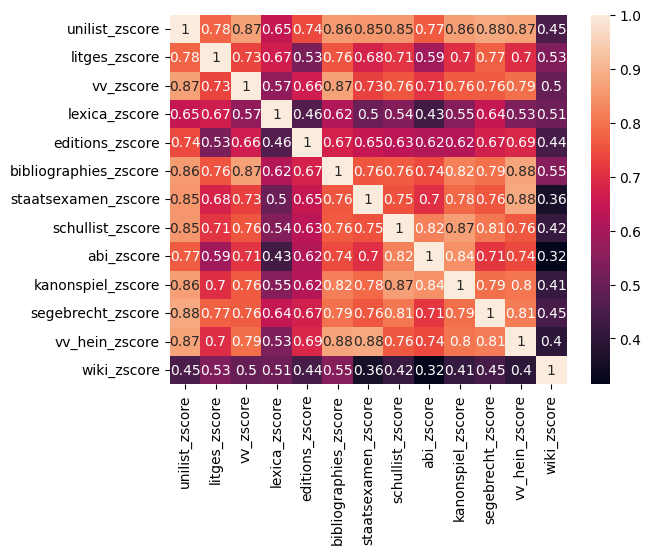

In [25]:
corr_results = (
    data
    .query("canonicity_score_rank <= 99999")
    [[x+'_zscore' for x in all_indicator_dict.keys()]]
    .apply(zscore)
    .corr(method='pearson')
    # .pipe(anonymize)
)

sns.heatmap(corr_results, annot=True)

In [26]:
thresholds = range(50, 6000, 50)

fig = go.Figure()

# add a scatter trace for each threshold
for i, t in enumerate(thresholds):
    filtered = (
        data
        .query(f"canonicity_score_rank <= {t}")
        [[x+'_zscore' for x in all_indicator_dict.keys()]]
        .apply(zscore)
        # .pipe(anonymize)
        .T
    )    
    components = PCA(n_components=2).fit_transform(filtered)
    
    fig.add_trace(go.Scatter(
        x=components[:, 0],
        y=components[:, 1],
        mode='markers+text',
        text=filtered.index,
        textposition='top center',
        marker=dict(size=8),
        name=f'Top {t}',
        visible=(i==0)  # only show the first initially
    ))

# create slider steps: each step makes only one trace visible
steps = []
for i, t in enumerate(thresholds):
    step = dict(
        method='update',
        args=[{'visible': [j == i for j in range(len(thresholds))]}],
        label=f'Top {t}'
    )
    steps.append(step)

# add slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Threshold: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [27]:
# Build lists: primary indicators and zscored secondary indicators
primary_indicators = [item+'_zscore' for item in list(all_indicator_dict.keys())]
secondary_indicators = [item+'_zscore' for sublist in all_indicator_dict.values() for item in sublist]

# All columns we need
all_columns = primary_indicators + secondary_indicators

# Filter data (here you can also apply your rank cutoff if you want)
data_compare = data.query("canonicity_score_rank<=999999999")[all_columns]

# Transpose so each column becomes a point in PCA
data_t = data_compare.T

# Run PCA
pca = PCA(n_components=2)
components = pca.fit_transform(data_t)

# Create DataFrame
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
pca_df['label'] = data_t.index


# Identify group and type
def find_group(label):
    # Remove '_zscore' suffix for matching
    original = label[:-7]  # strip '_zscore'
    
    if original in all_indicator_dict:  # Ensure it's in the dictionary keys (for primary)
        return original  # The primary indicator will return as its own group
    else:
        for group, sublist in all_indicator_dict.items():
            if original in sublist:
                return group
        return 'unknown'

def find_type(label):
    if label in primary_indicators:
        return 'primary'
    else:
        return 'secondary'

pca_df['group'] = pca_df['label'].apply(find_group)
pca_df['type'] = pca_df['label'].apply(find_type)

# Colors: one color per group
group_colors = px.colors.qualitative.Set1
unique_groups = list(all_indicator_dict.keys())
color_map = {group: group_colors[i % len(group_colors)] for i, group in enumerate(unique_groups)}

# Build figure
fig = go.Figure()

# Plot secondary indicators (only if group has more than one secondary), smaller, no outline
for group in unique_groups:
    color = color_map[group]
    subset = pca_df[(pca_df['group'] == group) & (pca_df['type'] == 'secondary')]
    
    if len(subset) > 1:
        fig.add_trace(go.Scatter(
            x=subset['PC1'],
            y=subset['PC2'],
            mode='markers',
            text=subset['label'],
            hoverinfo='text',
            marker=dict(size=8, color=color, line=dict(width=0)),
            name=f'{group} secondary'
        ))

# Plot primary indicators (larger, black ring)
for i, group in enumerate(unique_groups):
    color = color_map[group]
    subset = pca_df[(pca_df['group'] == group) & (pca_df['type'] == 'primary')]
    fig.add_trace(go.Scatter(
        x=subset['PC1'],
        y=subset['PC2'],
        mode='markers+text', # 👈 switch to markers+text to de-anonymize
        text=subset['label'],
        textposition='top center',
        marker=dict(size=12, color=color, line=dict(width=2, color='black')),
        name=f'{group} primary',  # Unique name for the legend
        showlegend=False  # hide primary from legend
    ))

# Update layout to ensure legend and visibility
fig.update_layout(
    width=900,
    height=700,
    showlegend=True  # 👈 switch to True to de-anonymize
)

# Show the plot
fig.show()

